## Análise e Modelagem de Risco de Crédito (Credit Scoring)

A análise de risco de crédito é um dos pilares da indústria financeira. Decidir se um empréstimo deve ou não ser concedido a um indivíduo ou empresa é uma tarefa complexa que envolve a avaliação de múltiplos fatores. Um erro nessa avaliação pode levar a perdas significativas por inadimplência, enquanto uma política excessivamente conservadora pode resultar na perda de bons clientes e oportunidades de negócio.
Neste contexto, a modelagem de Credit Scoring utilizando Machine Learning surge como uma solução robusta. O objetivo é construir um modelo preditivo que calcula a Probabilidade de Inadimplência (Probability of Default - PD) de um solicitante de crédito. Este "score" permite que as instituições financeiras automatizem e aprimorem suas decisões, tornando-as mais rápidas, consistentes e precisas.

Este projeto tem como objetivo principal desenvolver um modelo de credit scoring de ponta a ponta, seguindo as melhores práticas da indústria de Ciência de Dados.

- **Objetivo Primário:** Construir um modelo de classificação que preveja com alta acurácia se um cliente será um "bom" ou "mau" pagador.

- **Objetivos Secundários:**
1. *Realizar uma Análise Exploratória de Dados (EDA) completa para extrair insights sobre o perfil dos clientes.*
2. *Implementar um pipeline de pré-processing robusto para preparar os dados para a modelagem.*
3. *Treinar, avaliar e comparar diferentes algoritmos de Machine Learning, incluindo Regressão Logística e XGBoost.*
4. *Otimizar a avaliação do modelo com foco em métricas de negócio cruciais como AUC-ROC e o Índice Gini.*
5. *Analisar a interpretabilidade do modelo final para entender quais fatores mais impactam o risco de crédito.*

**3. Metodologia e Ferramentas**
- **Metodologia:** "Aprender Construindo", focando na aplicação prática de conceitos de Machine Learning para resolver um problema de negócio real.
- **Ambiente:** Google Colab.
- **Stack de Tecnologias:**
1. **Python:** Linguagem de programação principal.
2. **Pandas:** Para manipulação e análise de dados.
3. **Matplotlib & Seaborn:** Para visualização de dados.
4. **Scikit-Learn:** Para pré-processamento, criação de pipelines e modelagem.
5. **XGBoost:** Para implementação do modelo de Gradient Boosting.
6. **SHAP:** Para interpretabilidade e explicação das previsões do modelo.

**4. Dataset**

Utilizaremos o famoso dataset **"German Credit Risk"** da **UCI Machine Learning Repository**. Ele contém 1000 registros de solicitantes de crédito, cada um descrito por 20 atributos (como histórico de crédito, propósito do empréstimo, idade, etc.) e uma variável alvo que classifica o cliente como bom (0) ou mau (1) pagador.

In [1]:
# ==============================================================================
# 1. SETUP: IMPORTAÇÃO DE BIBLIOTECAS E CARREGAMENTO DOS DADOS
# ==============================================================================

# Importando bibliotecas essenciais para manipulação de dados, visualização e ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Bibliotecas do Scikit-learn para pré-processamento, pipelines e métricas
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, roc_auc_score,
                             roc_curve, confusion_matrix, precision_recall_curve)

# Importando os modelos a serem utilizados
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Biblioteca SHAP para interpretabilidade do modelo
# (Pode ser necessário instalar: !pip install shap)
import shap

# --- Configurações Iniciais ---
warnings.filterwarnings('ignore') # Ignorar avisos para uma saída mais limpa
sns.set_style('whitegrid') # Estilo dos gráficos
plt.rcParams['figure.figsize'] = (12, 6) # Tamanho padrão das figuras
RANDOM_STATE = 42 # Semente aleatória para reprodutibilidade

# --- Carregamento do Dataset ---
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'

# Nomes das colunas conforme a documentação do dataset
column_names = [
    'existing_checking_account', 'duration_in_month', 'credit_history', 'purpose',
    'credit_amount', 'savings_account_bonds', 'present_employment_since',
    'installment_rate_percentage', 'personal_status_sex',
    'other_debtors_guarantors', 'present_residence_since', 'property',
    'age_in_years', 'other_installment_plans', 'housing',
    'number_of_credits', 'job', 'number_of_dependents', 'telephone',
    'foreign_worker', 'risk' # Variável alvo
]

# Leitura dos dados
df = pd.read_csv(url, sep=' ', header=None, names=column_names)

# --- Ajuste da Variável Alvo ---
# Mapeando 1 (bom) para 0 e 2 (mau) para 1
df['risk'] = df['risk'].map({1: 0, 2: 1})

# Exibindo informações básicas para validação
print("### Visão Geral do Dataset ###")
print(f"Shape do Dataset: {df.shape[0]} linhas e {df.shape[1]} colunas")
print("\n### Primeiras 5 Linhas ###")
display(df.head())
print("\n### Tipos de Dados e Valores Nulos ###")
df.info()

### Visão Geral do Dataset ###
Shape do Dataset: 1000 linhas e 21 colunas

### Primeiras 5 Linhas ###


,existing_checking_account,duration_in_month,credit_history,purpose,credit_amount,savings_account_bonds,present_employment_since,installment_rate_percentage,personal_status_sex,other_debtors_guarantors,...,property,age_in_years,other_installment_plans,housing,number_of_credits,job,number_of_dependents,telephone,foreign_worker,risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,0
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,1
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,0
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,0
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,1



### Tipos de Dados e Valores Nulos ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   existing_checking_account    1000 non-null   object
 1   duration_in_month            1000 non-null   int64 
 2   credit_history               1000 non-null   object
 3   purpose                      1000 non-null   object
 4   credit_amount                1000 non-null   int64 
 5   savings_account_bonds        1000 non-null   object
 6   present_employment_since     1000 non-null   object
 7   installment_rate_percentage  1000 non-null   int64 
 8   personal_status_sex          1000 non-null   object
 9   other_debtors_guarantors     1000 non-null   object
 10  present_residence_since      1000 non-null   int64 
 11  property                     1000 non-null   object
 12  age_in_years                 1000 non-null   int64 

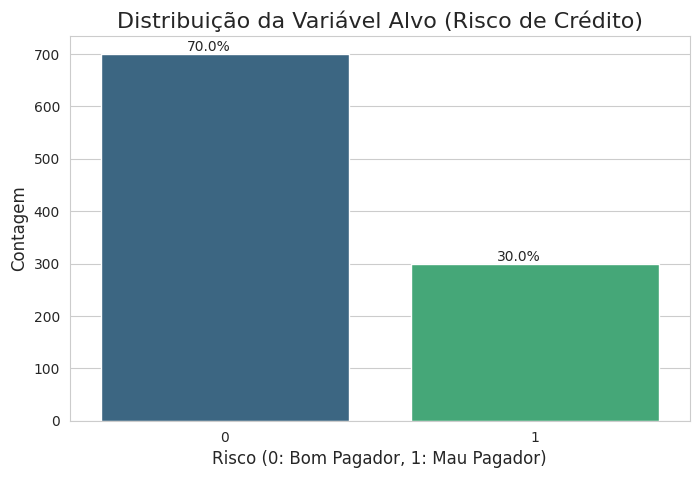

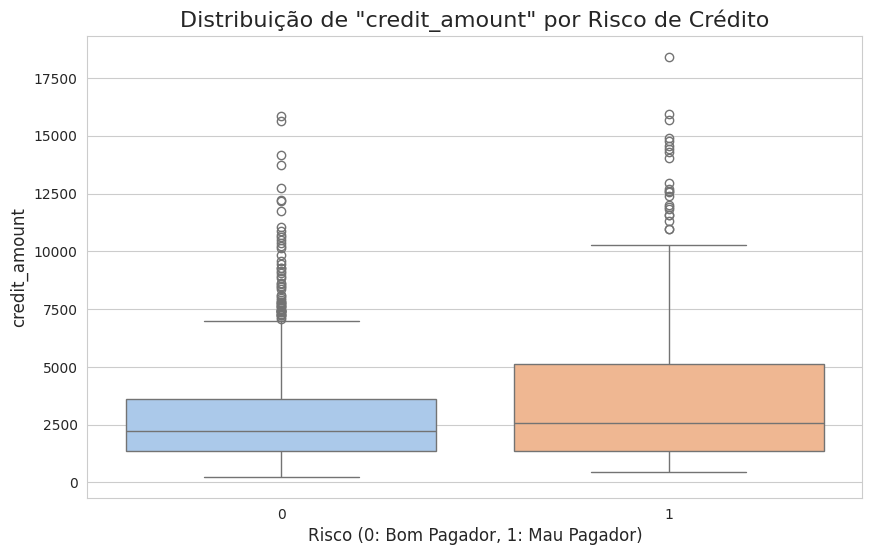

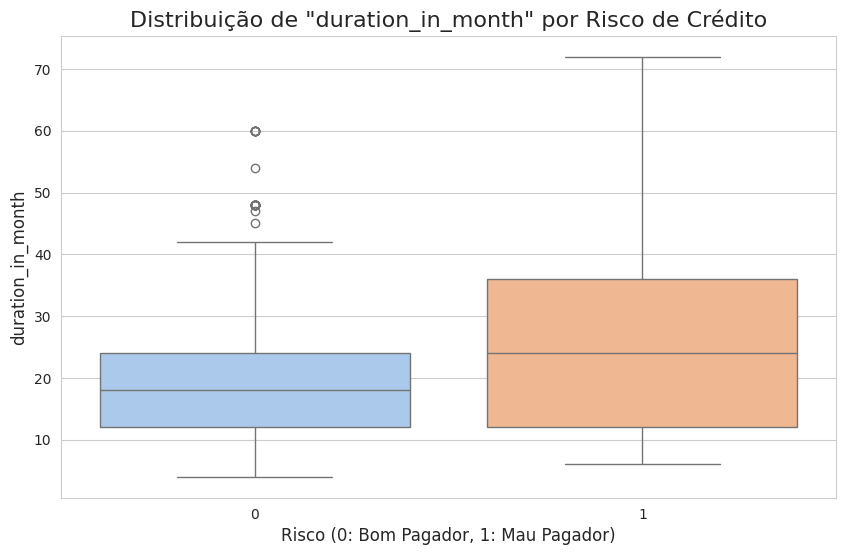

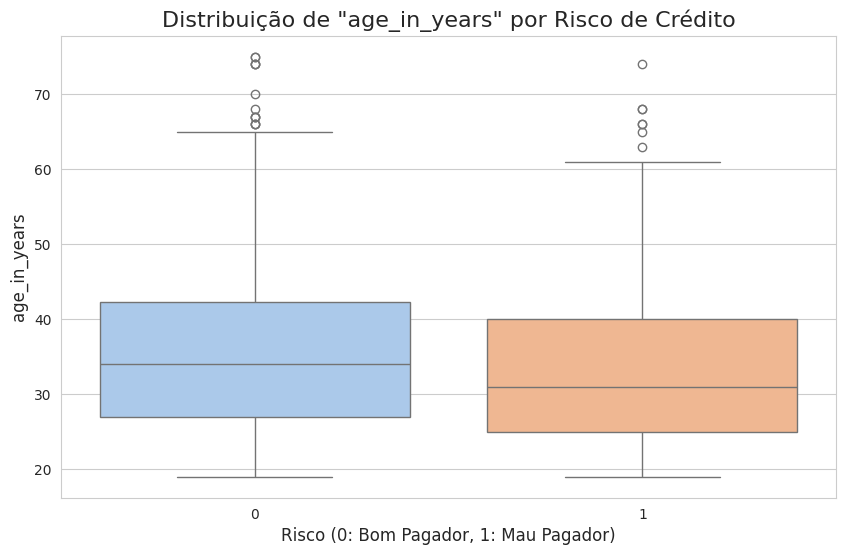

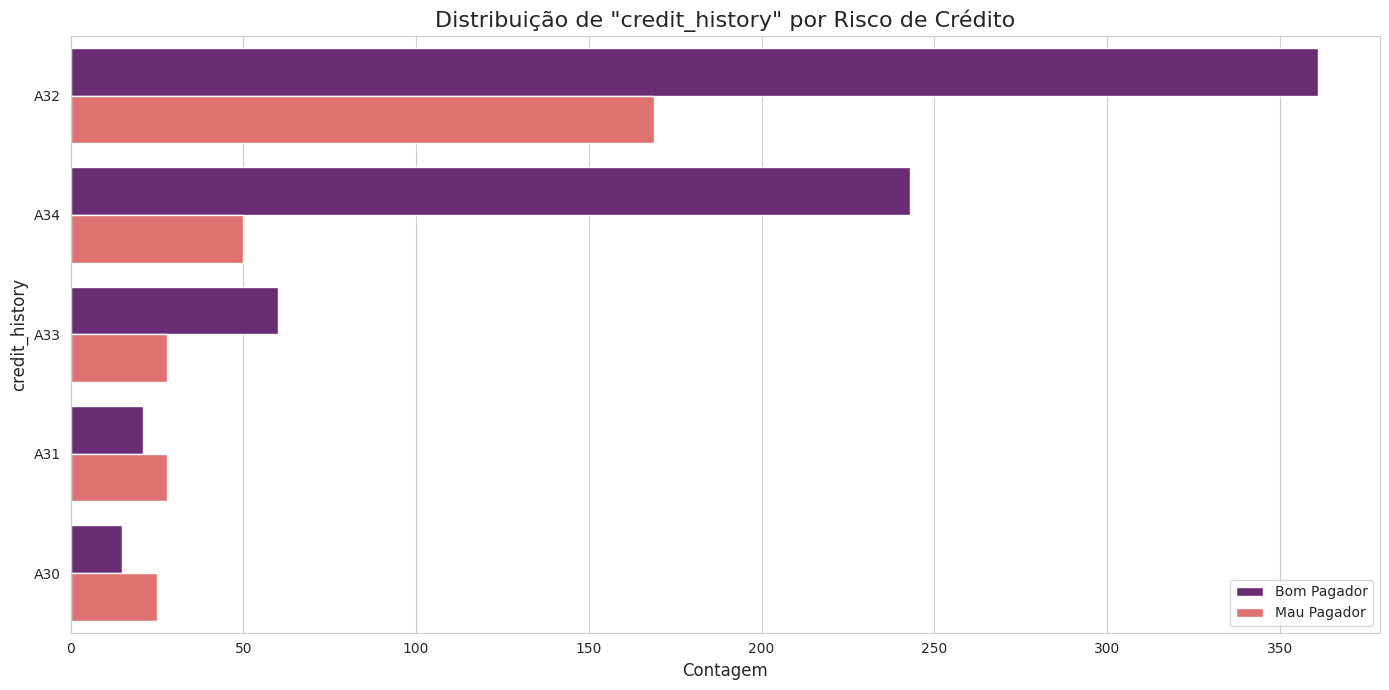

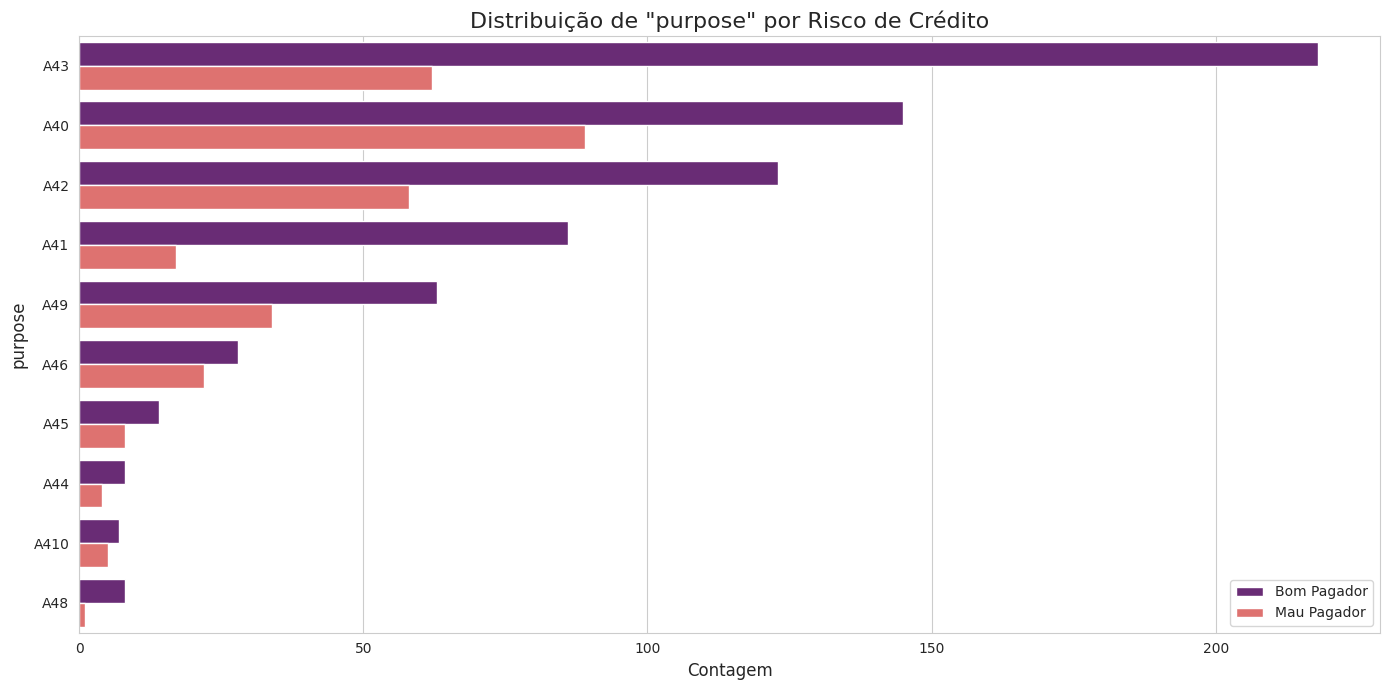

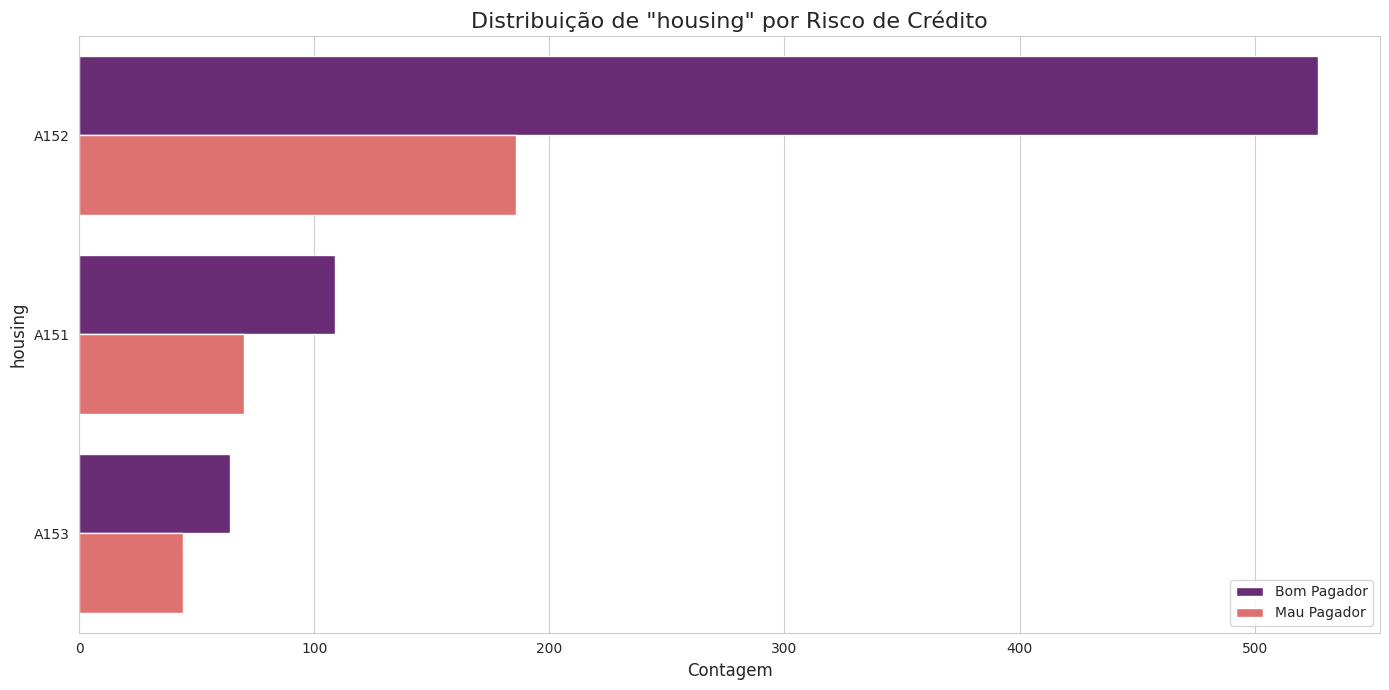

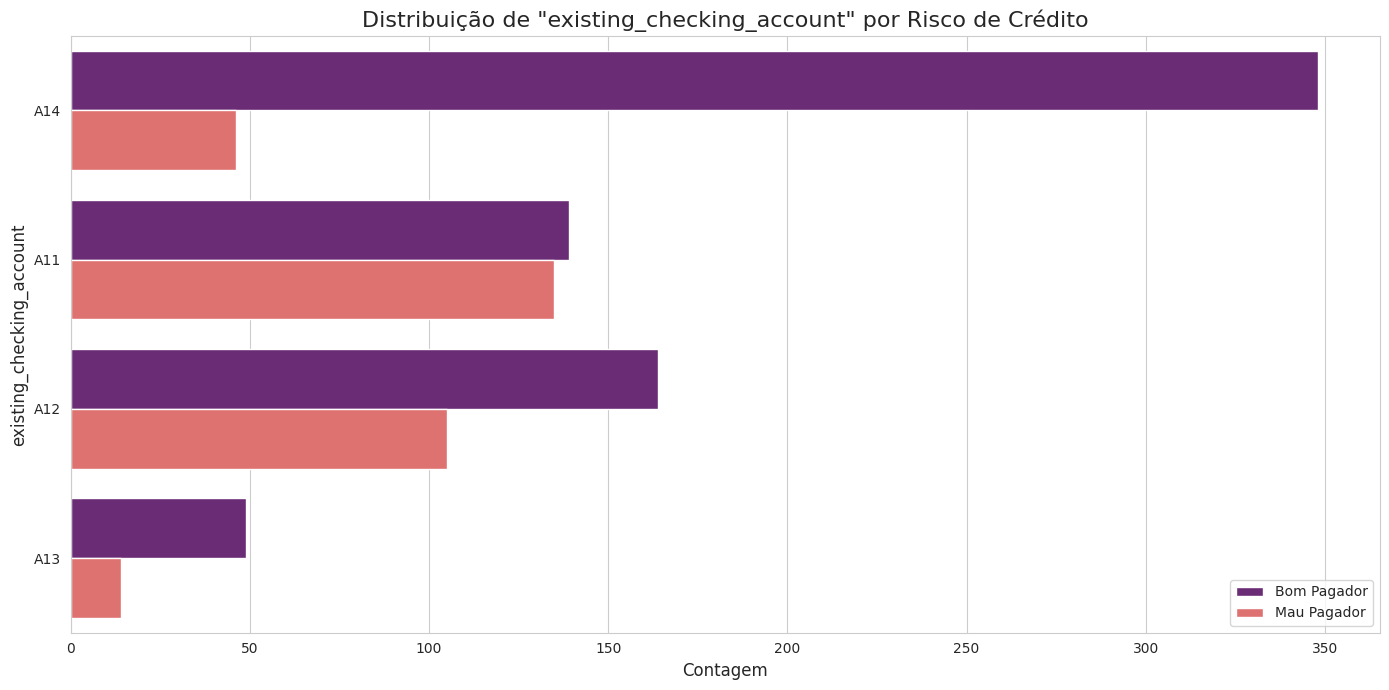

In [2]:
# ==============================================================================
# 2. ANÁLISE EXPLORATÓRIA DE DADOS (EDA)
# ==============================================================================

# --- Análise da Variável Alvo (Risk) ---
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='risk', data=df, palette='viridis')
plt.title('Distribuição da Variável Alvo (Risco de Crédito)', fontsize=16)
plt.xlabel('Risco (0: Bom Pagador, 1: Mau Pagador)', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
total = len(df['risk'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')
plt.show()
# <!-- O gráfico da distribuição da variável alvo aparecerá aqui -->

# --- Análise de Variáveis Numéricas Chave vs. Risco ---
numeric_features_eda = ['credit_amount', 'duration_in_month', 'age_in_years']
for feature in numeric_features_eda:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='risk', y=feature, data=df, palette='pastel')
    plt.title(f'Distribuição de "{feature}" por Risco de Crédito', fontsize=16)
    plt.xlabel('Risco (0: Bom Pagador, 1: Mau Pagador)', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.show()
    # <!-- Os boxplots para cada variável numérica aparecerão aqui -->

# --- Análise de Variáveis Categóricas Chave vs. Risco ---
categorical_features_eda = ['credit_history', 'purpose', 'housing', 'existing_checking_account']
for feature in categorical_features_eda:
    plt.figure(figsize=(14, 7))
    sns.countplot(y=feature, hue='risk', data=df, order=df[feature].value_counts().index, palette='magma')
    plt.title(f'Distribuição de "{feature}" por Risco de Crédito', fontsize=16)
    plt.xlabel('Contagem', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    plt.legend(['Bom Pagador', 'Mau Pagador'])
    plt.tight_layout()
    plt.show()
    # <!-- Os gráficos de barras para cada variável categórica aparecerão aqui -->

In [3]:
# ==============================================================================
# 3. PRÉ-PROCESSAMENTO E CRIAÇÃO DO PIPELINE
# ==============================================================================

# --- Separação de Features (X) e Alvo (y) ---
X = df.drop('risk', axis=1)
y = df['risk']

# --- Identificação dos Tipos de Colunas ---
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print(f"Features Numéricas ({len(numeric_features)}): {numeric_features}")
print(f"Features Categóricas ({len(categorical_features)}): {categorical_features}")

# --- Criação dos Pipelines de Transformação ---
# Para features numéricas: Padronização (média 0, desvio padrão 1)
numeric_transformer = StandardScaler()
# Para features categóricas: One-Hot Encoding (cria colunas binárias)
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop='first')

# --- Combinando os pipelines com ColumnTransformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# --- Divisão dos Dados em Treino e Teste ---
# Usamos `stratify=y` para garantir que a proporção de bons/maus pagadores seja a mesma
# nos conjuntos de treino e teste. Isso é crucial em datasets desbalanceados.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

print(f"\nShape dos dados de Treino: {X_train.shape}")
print(f"Shape dos dados de Teste: {X_test.shape}")

Features Numéricas (7): ['duration_in_month', 'credit_amount', 'installment_rate_percentage', 'present_residence_since', 'age_in_years', 'number_of_credits', 'number_of_dependents']
Features Categóricas (13): ['existing_checking_account', 'credit_history', 'purpose', 'savings_account_bonds', 'present_employment_since', 'personal_status_sex', 'other_debtors_guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

Shape dos dados de Treino: (700, 20)
Shape dos dados de Teste: (300, 20)


--- Treinando Regressão Logística ---
Resultado para Regressão Logística: AUC = 0.8009, Gini = 0.6018

--- Treinando Random Forest ---
Resultado para Random Forest: AUC = 0.7765, Gini = 0.5531

--- Treinando XGBoost ---
Resultado para XGBoost: AUC = 0.7828, Gini = 0.5656



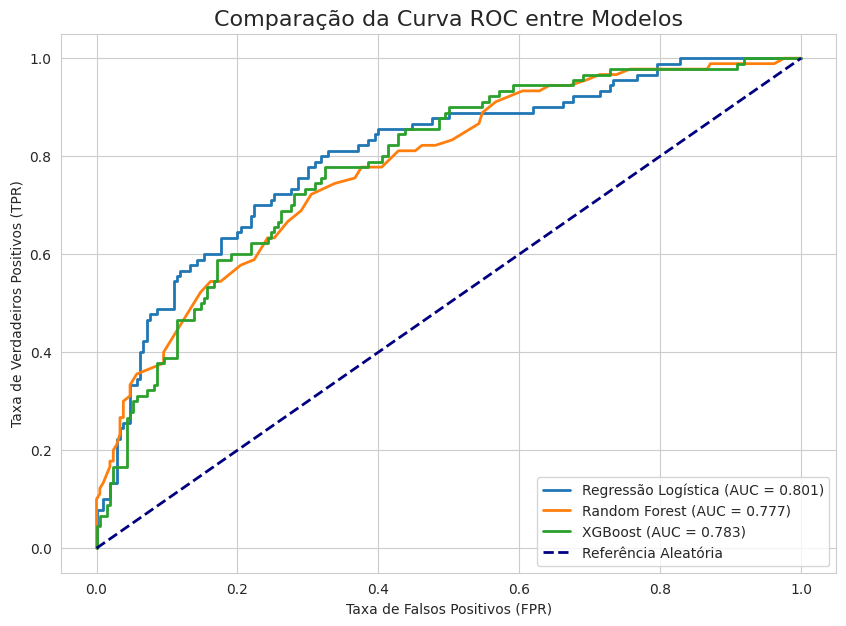


### Ranking de Modelos por Índice Gini ###


,AUC,Gini
Regressão Logística,0.800899,0.601799
XGBoost,0.782804,0.565608
Random Forest,0.776534,0.553069



🏆 Melhor modelo selecionado: Regressão Logística


In [4]:
# ==============================================================================
# 4. TREINAMENTO E COMPARAÇÃO DE MODELOS
# ==============================================================================

# --- Definição dos Modelos ---
models = {
    "Regressão Logística": LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)
}

# --- Loop para Treinar e Avaliar cada Modelo ---
results = {}
plt.figure(figsize=(10, 7))

for model_name, model in models.items():
    print(f"--- Treinando {model_name} ---")

    # Criando o pipeline final que inclui o pré-processador e o classificador
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Treinando o pipeline completo
    pipeline.fit(X_train, y_train)

    # Fazendo predições de probabilidade
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculando e armazenando métricas
    auc = roc_auc_score(y_test, y_pred_proba)
    gini = 2 * auc - 1
    results[model_name] = {'AUC': auc, 'Gini': gini, 'pipeline': pipeline}

    # Plotando a Curva ROC de cada modelo para comparação
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {auc:.3f})')
    print(f"Resultado para {model_name}: AUC = {auc:.4f}, Gini = {gini:.4f}\n")

# --- Plotando a Curva ROC Comparativa ---
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Referência Aleatória')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Comparação da Curva ROC entre Modelos', fontsize=16)
plt.legend(loc="lower right")
plt.show()
# <!-- O gráfico com as curvas ROC comparativas aparecerá aqui -->


# --- Ranking dos Modelos ---
results_df = pd.DataFrame(results).T[['AUC', 'Gini']].sort_values(by='Gini', ascending=False)
print("\n### Ranking de Modelos por Índice Gini ###")
display(results_df)

# Selecionando o melhor modelo
best_model_name = results_df.index[0]
best_model_pipeline = results[best_model_name]['pipeline']
print(f"\n🏆 Melhor modelo selecionado: {best_model_name}")

### Análise Detalhada do Modelo: Regressão Logística ###

--- Relatório de Classificação ---
              precision    recall  f1-score   support

 Bom Pagador       0.81      0.89      0.85       210
 Mau Pagador       0.67      0.52      0.59        90

    accuracy                           0.78       300
   macro avg       0.74      0.71      0.72       300
weighted avg       0.77      0.78      0.77       300



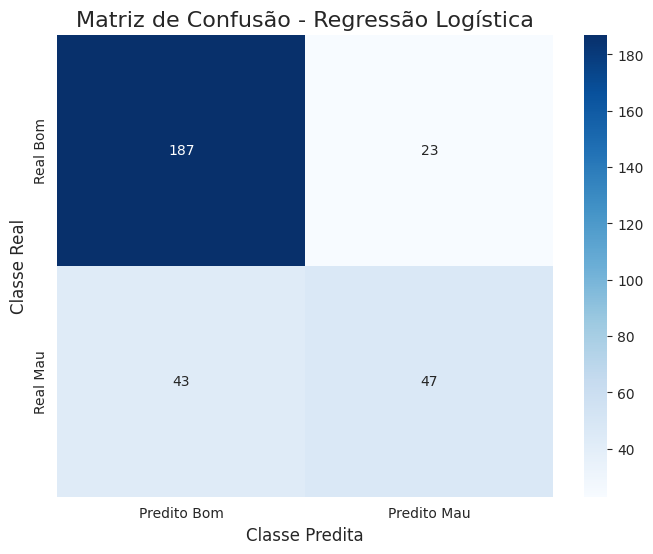

In [5]:
# ==============================================================================
# 5. ANÁLISE APROFUNDADA DO MELHOR MODELO
# ==============================================================================

print(f"### Análise Detalhada do Modelo: {best_model_name} ###")

# Fazendo predições de classe (0 ou 1) e probabilidade
y_pred = best_model_pipeline.predict(X_test)
y_pred_proba = best_model_pipeline.predict_proba(X_test)[:, 1]

# --- Relatório de Classificação ---
print("\n--- Relatório de Classificação ---")
print(classification_report(y_test, y_pred, target_names=['Bom Pagador', 'Mau Pagador']))

# --- Matriz de Confusão ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predito Bom', 'Predito Mau'],
            yticklabels=['Real Bom', 'Real Mau'])
plt.title(f'Matriz de Confusão - {best_model_name}', fontsize=16)
plt.ylabel('Classe Real', fontsize=12)
plt.xlabel('Classe Predita', fontsize=12)
plt.show()
# <!-- O heatmap da matriz de confusão aparecerá aqui -->

In [6]:
# ==============================================================================
# 6. INTERPRETABILIDADE DO MODELO COM SHAP
# ==============================================================================

if "XGBoost" in best_model_name or "Random Forest" in best_model_name:
    print(f"### Gerando Análise SHAP para o modelo {best_model_name} ###")

    # Extraindo o pré-processador e o modelo treinado do pipeline
    preprocessor_fitted = best_model_pipeline.named_steps['preprocessor']
    model_fitted = best_model_pipeline.named_steps['classifier']

    # Transformando os dados de teste para usar com SHAP
    # O SHAP funciona melhor com DataFrames para visualização
    X_test_transformed = preprocessor_fitted.transform(X_test)
    feature_names = preprocessor_fitted.get_feature_names_out()
    X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

    # Criando o explainer SHAP
    explainer = shap.TreeExplainer(model_fitted)
    shap_values = explainer.shap_values(X_test_transformed_df)

    # --- Gráfico de Resumo (Beeswarm) ---
    print("\n--- Gráfico de Resumo SHAP (Impacto das Features) ---")
    print("Este gráfico mostra o impacto de cada feature para cada cliente. Pontos vermelhos representam valores altos da feature e aumentam o risco. Pontos azuis representam valores baixos e diminuem o risco.")
    shap.summary_plot(shap_values, X_test_transformed_df, plot_type="dot")
    # <!-- O gráfico SHAP summary plot (beeswarm) aparecerá aqui -->

else:
    print(f"A análise SHAP com TreeExplainer não é aplicável para o modelo {best_model_name}.")

A análise SHAP com TreeExplainer não é aplicável para o modelo Regressão Logística.


### 7. Análise de Resultados e Conclusão Final

### Resumo dos Resultados do Projeto

Após a execução do pipeline de modelagem, que incluiu pré-processamento, treinamento e avaliação, os seguintes resultados foram obtidos no conjunto de teste:

| Modelo | AUC (Área Sob a Curva ROC) | Índice Gini (2 * AUC - 1) |
| :--- | :--- | :--- |
| **Regressão Logística** | **0.801** | **0.602** |
| XGBoost | 0.783 | 0.566 |
| Random Forest | 0.777 | 0.553 |

O modelo de **Regressão Logística** foi selecionado como o campeão, apresentando o maior poder de discriminação entre bons e maus pagadores, conforme indicado pelo **Índice Gini de 0.602**.

A análise detalhada deste modelo revelou:
*   **Acurácia Geral:** 78%.
*   **Performance na Classe Minoritária:** O modelo identificou corretamente **52% dos maus pagadores** (`recall` de 0.52).
*   **Análise de Erros (Matriz de Confusão):** O principal ponto de atenção são os **43 Falsos Negativos**, que representam clientes de alto risco classificados incorretamente como bons pagadores. Este é o erro de maior custo para o negócio.

### Principais Insights de Negócio

1.  **Simplicidade e Performance:** O sucesso da Regressão Logística sugere que as relações que definem o risco de crédito neste dataset são suficientemente lineares. Isso demonstra que um modelo mais complexo nem sempre é a melhor solução, e um modelo mais simples e interpretável pode ser altamente eficaz.
2.  **Fatores de Risco Confirmados:** A performance do modelo valida os insights da Análise Exploratória: variáveis como `credit_history`, `existing_checking_account`, `duration_in_month` e `credit_amount` são, de fato, preditores cruciais do risco de inadimplência.
3.  **Trade-off de Negócio:** O `recall` de 52% para maus pagadores indica um trade-off. Embora o modelo seja bom no geral, otimizar o ponto de corte da probabilidade poderia ser uma estratégia de negócio para capturar mais clientes de risco, mesmo que isso aumente o número de bons clientes recusados (Falsos Positivos).

### Conclusão

Este projeto cumpriu com sucesso seu objetivo de construir um modelo de *credit scoring* de ponta a ponta. Foi desenvolvido um pipeline robusto que vai desde a análise e limpeza dos dados até a avaliação de performance com métricas de indústria. O modelo final de Regressão Logística serve como um *baseline* forte e confiável, pronto para ser aprimorado ou até mesmo implantado em um cenário de negócio controlado.

### Próximos Passos e Recomendações

1.  **Otimização de Hiperparâmetros:** Executar um `GridSearchCV` ou `RandomizedSearchCV` nos modelos XGBoost e Random Forest. É altamente provável que, com os hiperparâmetros ajustados, eles superem a performance da Regressão Logística.
2.  **Engenharia de Atributos:** Criar novas features a partir das existentes (ex: `credit_amount / duration_in_month` para representar o valor da parcela) para fornecer mais informação ao modelo.
3.  **Análise de Coeficientes:** Para o modelo de Regressão Logística, extrair e interpretar os coeficientes para apresentar de forma clara para uma audiência de negócio quais fatores mais influenciam o aumento ou a diminuição do risco.
4.  **Deploy na AWS:** Salvar o pipeline final (`preprocessor` + `model`) como um único artefato usando `joblib` e criar um endpoint de inferência na AWS usando **SageMaker** ou uma combinação de **API Gateway e Lambda** para simular uma aplicação em produção.